In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util
from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt

First, we copy and paste code from the Basic Planck Example.

In [3]:
# create an Observables object to store information for derivatives

pars = np.array( ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff'])
centers = np.array([0.0224, 0.12,      0.69,  2.2e-9, 0.96, 0.07, 0])

steps = np.array([0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, 2e-26])

fisher = [[2541344108.038636, -487335175.1650552, -135819256.2122977, 2.02071926410754e+16, 54818695.15853991, -85954674.42374833, -1.7887344704859805e+30], [-487335175.1650552, 191753639.00562784, 49339990.81445541, -4201492357878549.5, -8448333.133660374, 18076151.6704248, 2.1443580673638813e+28], [-135819256.2122977, 49339990.81445542, 13151932.5773979, -957163264536608.1, -2204352.657204268, 4032628.7598444205, 8.719858271299403e+27], [2.0207192641075396e+16, -4201492357878549.5, -957163264536608.1, 5.319720064847968e+23, 1002879514557355.2, -2271511458593777.0, -4.1884995170302195e+37], [54818695.15853991, -8448333.133660374, -2204352.657204268, 1002879514557355.2, 2330385.549230009, -4297882.667672092, -9.664428904286152e+28], [-85954674.42374833, 18076151.6704248, 4032628.7598444205, -2271511458593777.0, -4297882.667672091, 9751016.687015843, 1.7757603406957102e+29], [-1.7887344704859803e+30, 2.144358067363883e+28, 8.719858271299403e+27, -4.1884995170302195e+37, -9.664428904286152e+28, 1.7757603406957102e+29, 4.9609868045116285e+51]]

cov = np.linalg.inv(fisher)
#fishchips.util.plot_triangle(obs, cov);

# Arbitrary Priors

We use arbitrary priors by sampling and then plotting triangle plots with corner.py.

In [4]:
import corner

def unitize_cov(imp_cov, scales):
    imp_cov = imp_cov.copy()
    npar = imp_cov.shape[0]
    for i in range(npar):
        for j in range(npar):
            imp_cov[i,j] *= scales[i] * scales[j]
    return imp_cov

def get_samps(inp_cov, inp_means, num=int(1e8)):
    """
    Generate samples from a covariance matrix and input means.
    
    Parameters
    ----------
        inp_cov (2D numpy array) : covariance matrix from Fisher
        inp_means (1D numpy array) : mean values (mu), fiducial from Fisher
        
    Returns
    -------
        2D numpy array with each row corresponding to one random draw 
        from the multivariate Gaussian
    """
    samps = np.random.multivariate_normal( np.array(inp_means)/np.sqrt(np.diag(inp_cov)), 
                                           unitize_cov(inp_cov,1./np.sqrt(np.diag(inp_cov))), int(1e7))
    samps = samps[samps.T[-1]>0]
    for i in range(inp_cov.shape[0]):
        samps.T[i] *= np.sqrt(inp_cov[i,i])
        
    return samps


For example, we can just make the same plot we had just made, but this time with sampling.

In [5]:
unmodified_samples = get_samps(cov, centers)

In [6]:
unmodified_samples.shape

(5000468, 7)

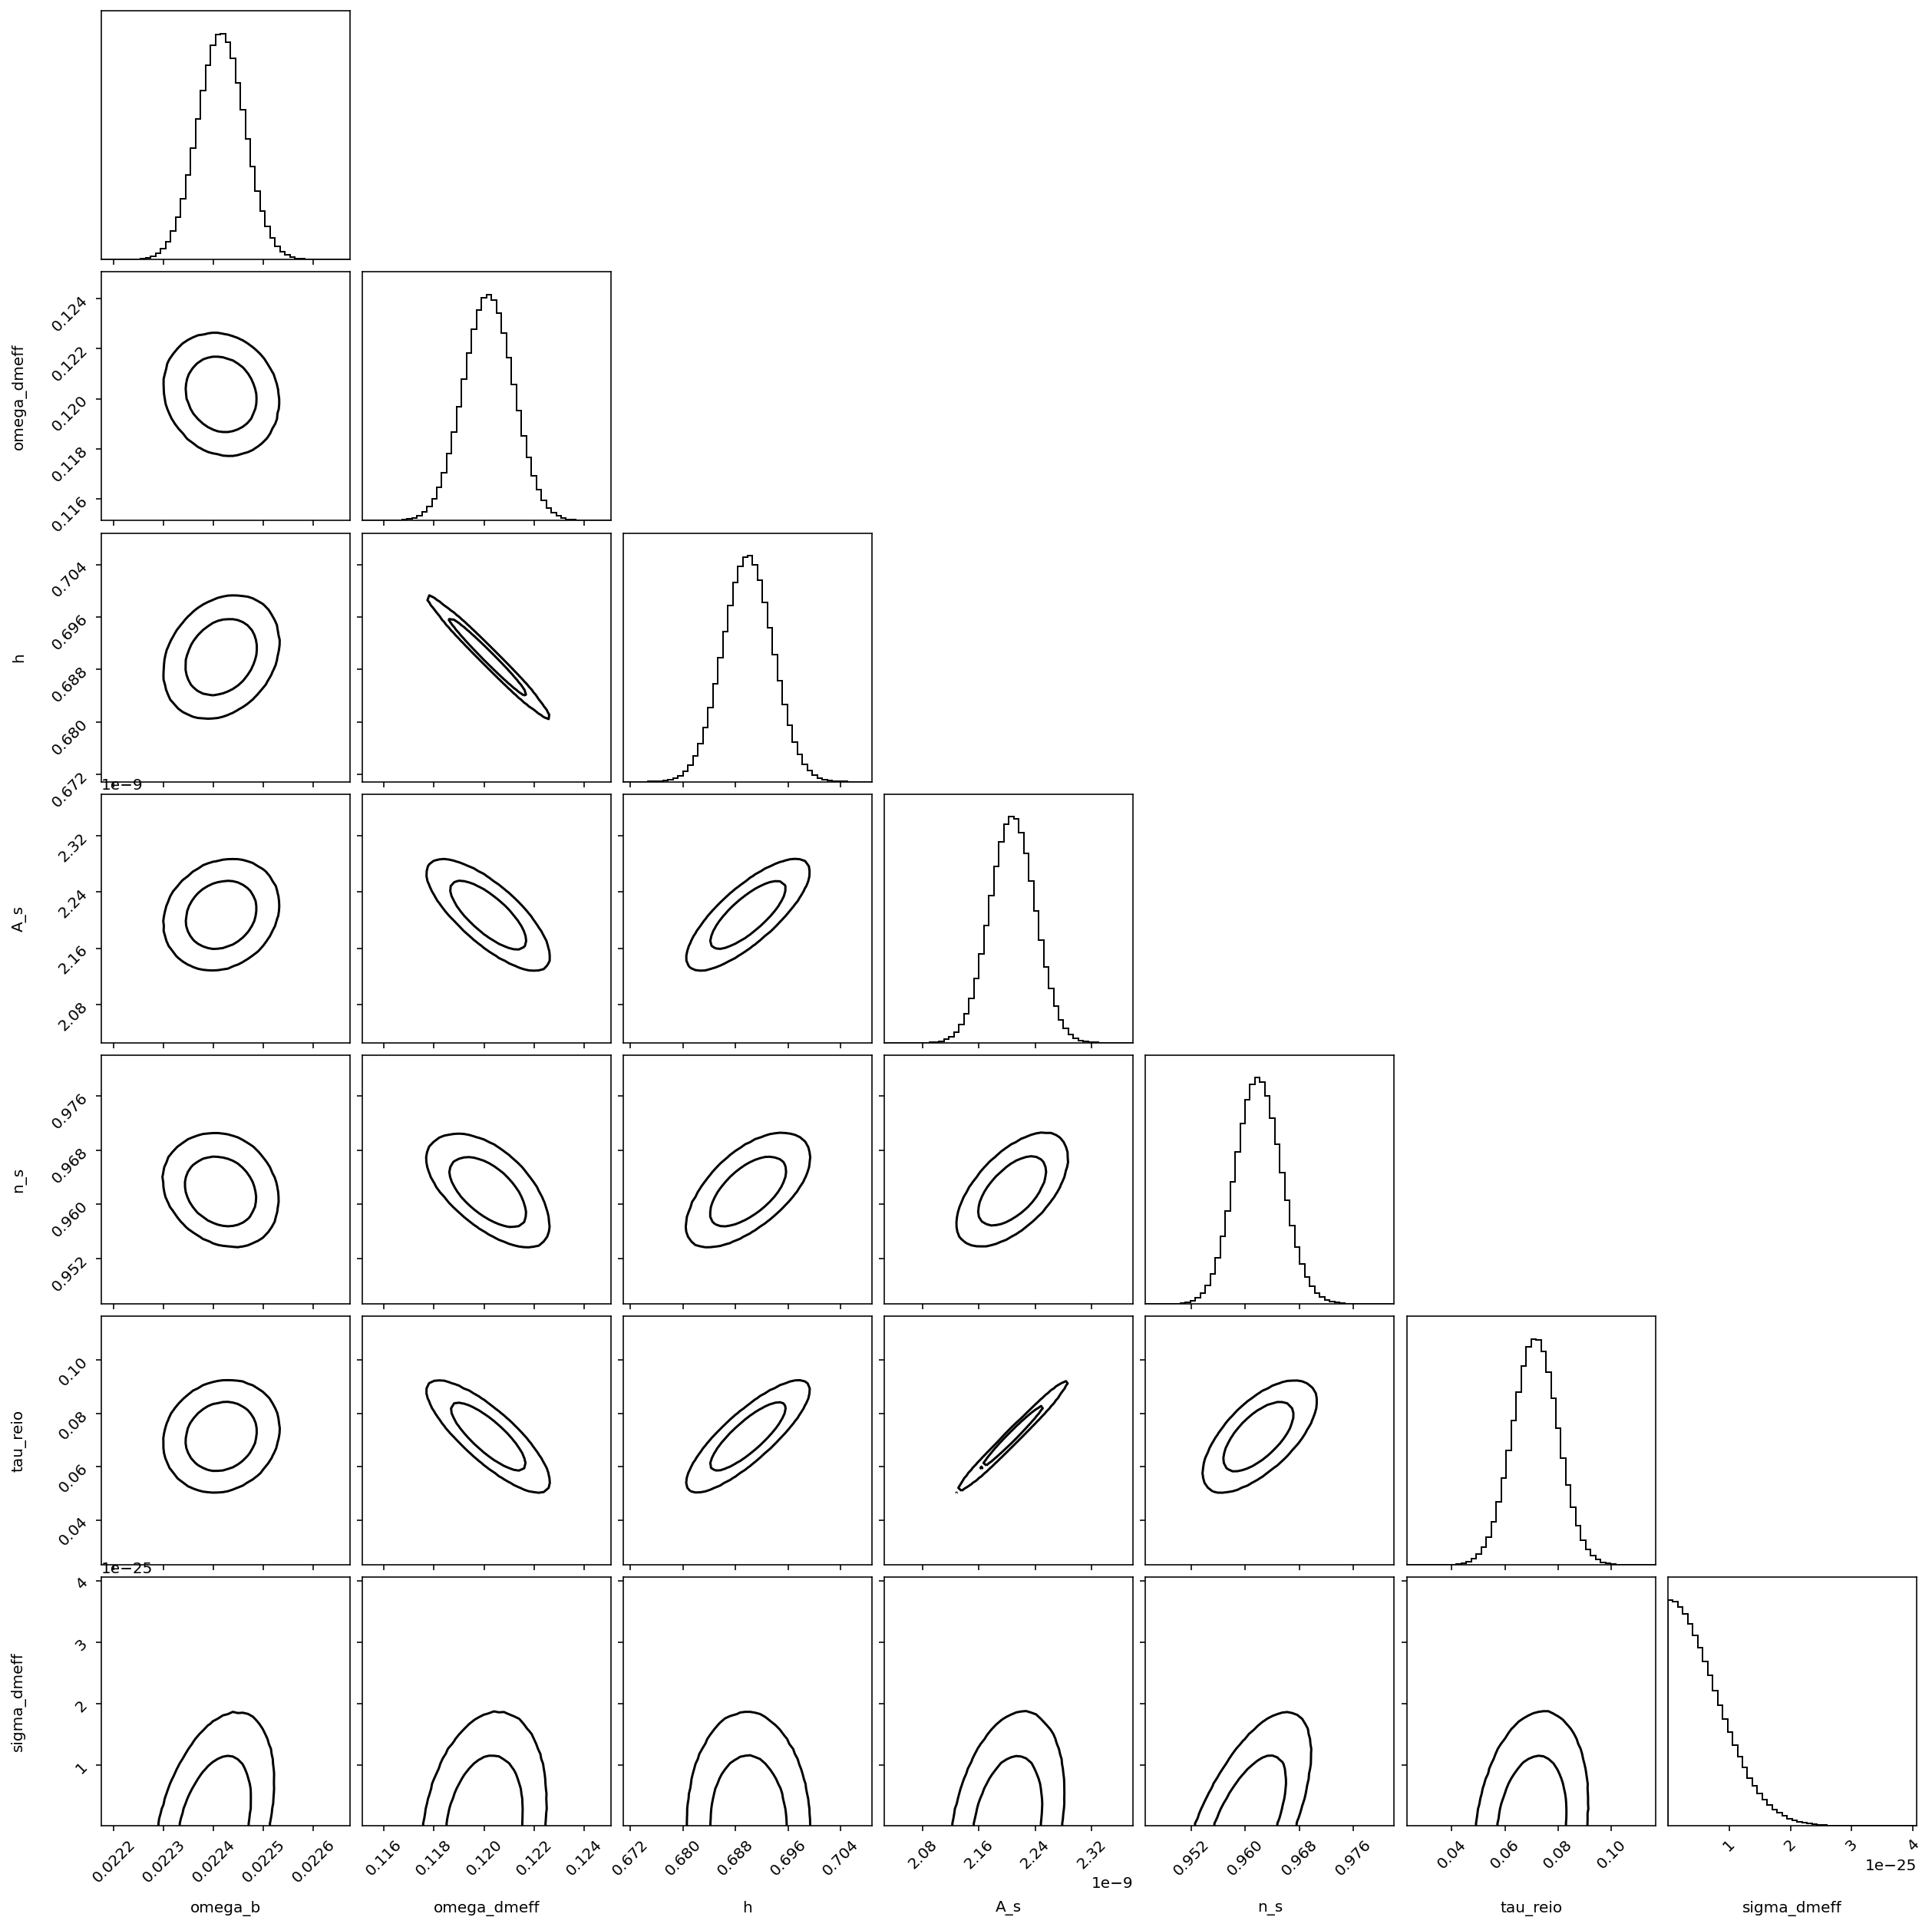

In [7]:
npar = cov.shape[0]
fig, ax = plt.subplots(npar, npar, figsize=(18,18))

corner.corner(unmodified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff']);


Now we can modify these samples. Let's change $\tau_{reio}$ into the parameter $\tau_{reio}^3$, and **also weight it by $\tau$**.

In [8]:
modified_samples = unmodified_samples.copy()
modified_samples.T[-1] = unmodified_samples.T[-1]**3 # change the last column (i.e. tau) 

In [9]:
modified_samples.T[-1]

array([1.61387463e-76, 4.54858415e-76, 3.23515578e-76, ...,
       5.27190936e-75, 4.64031536e-78, 5.93550706e-76])

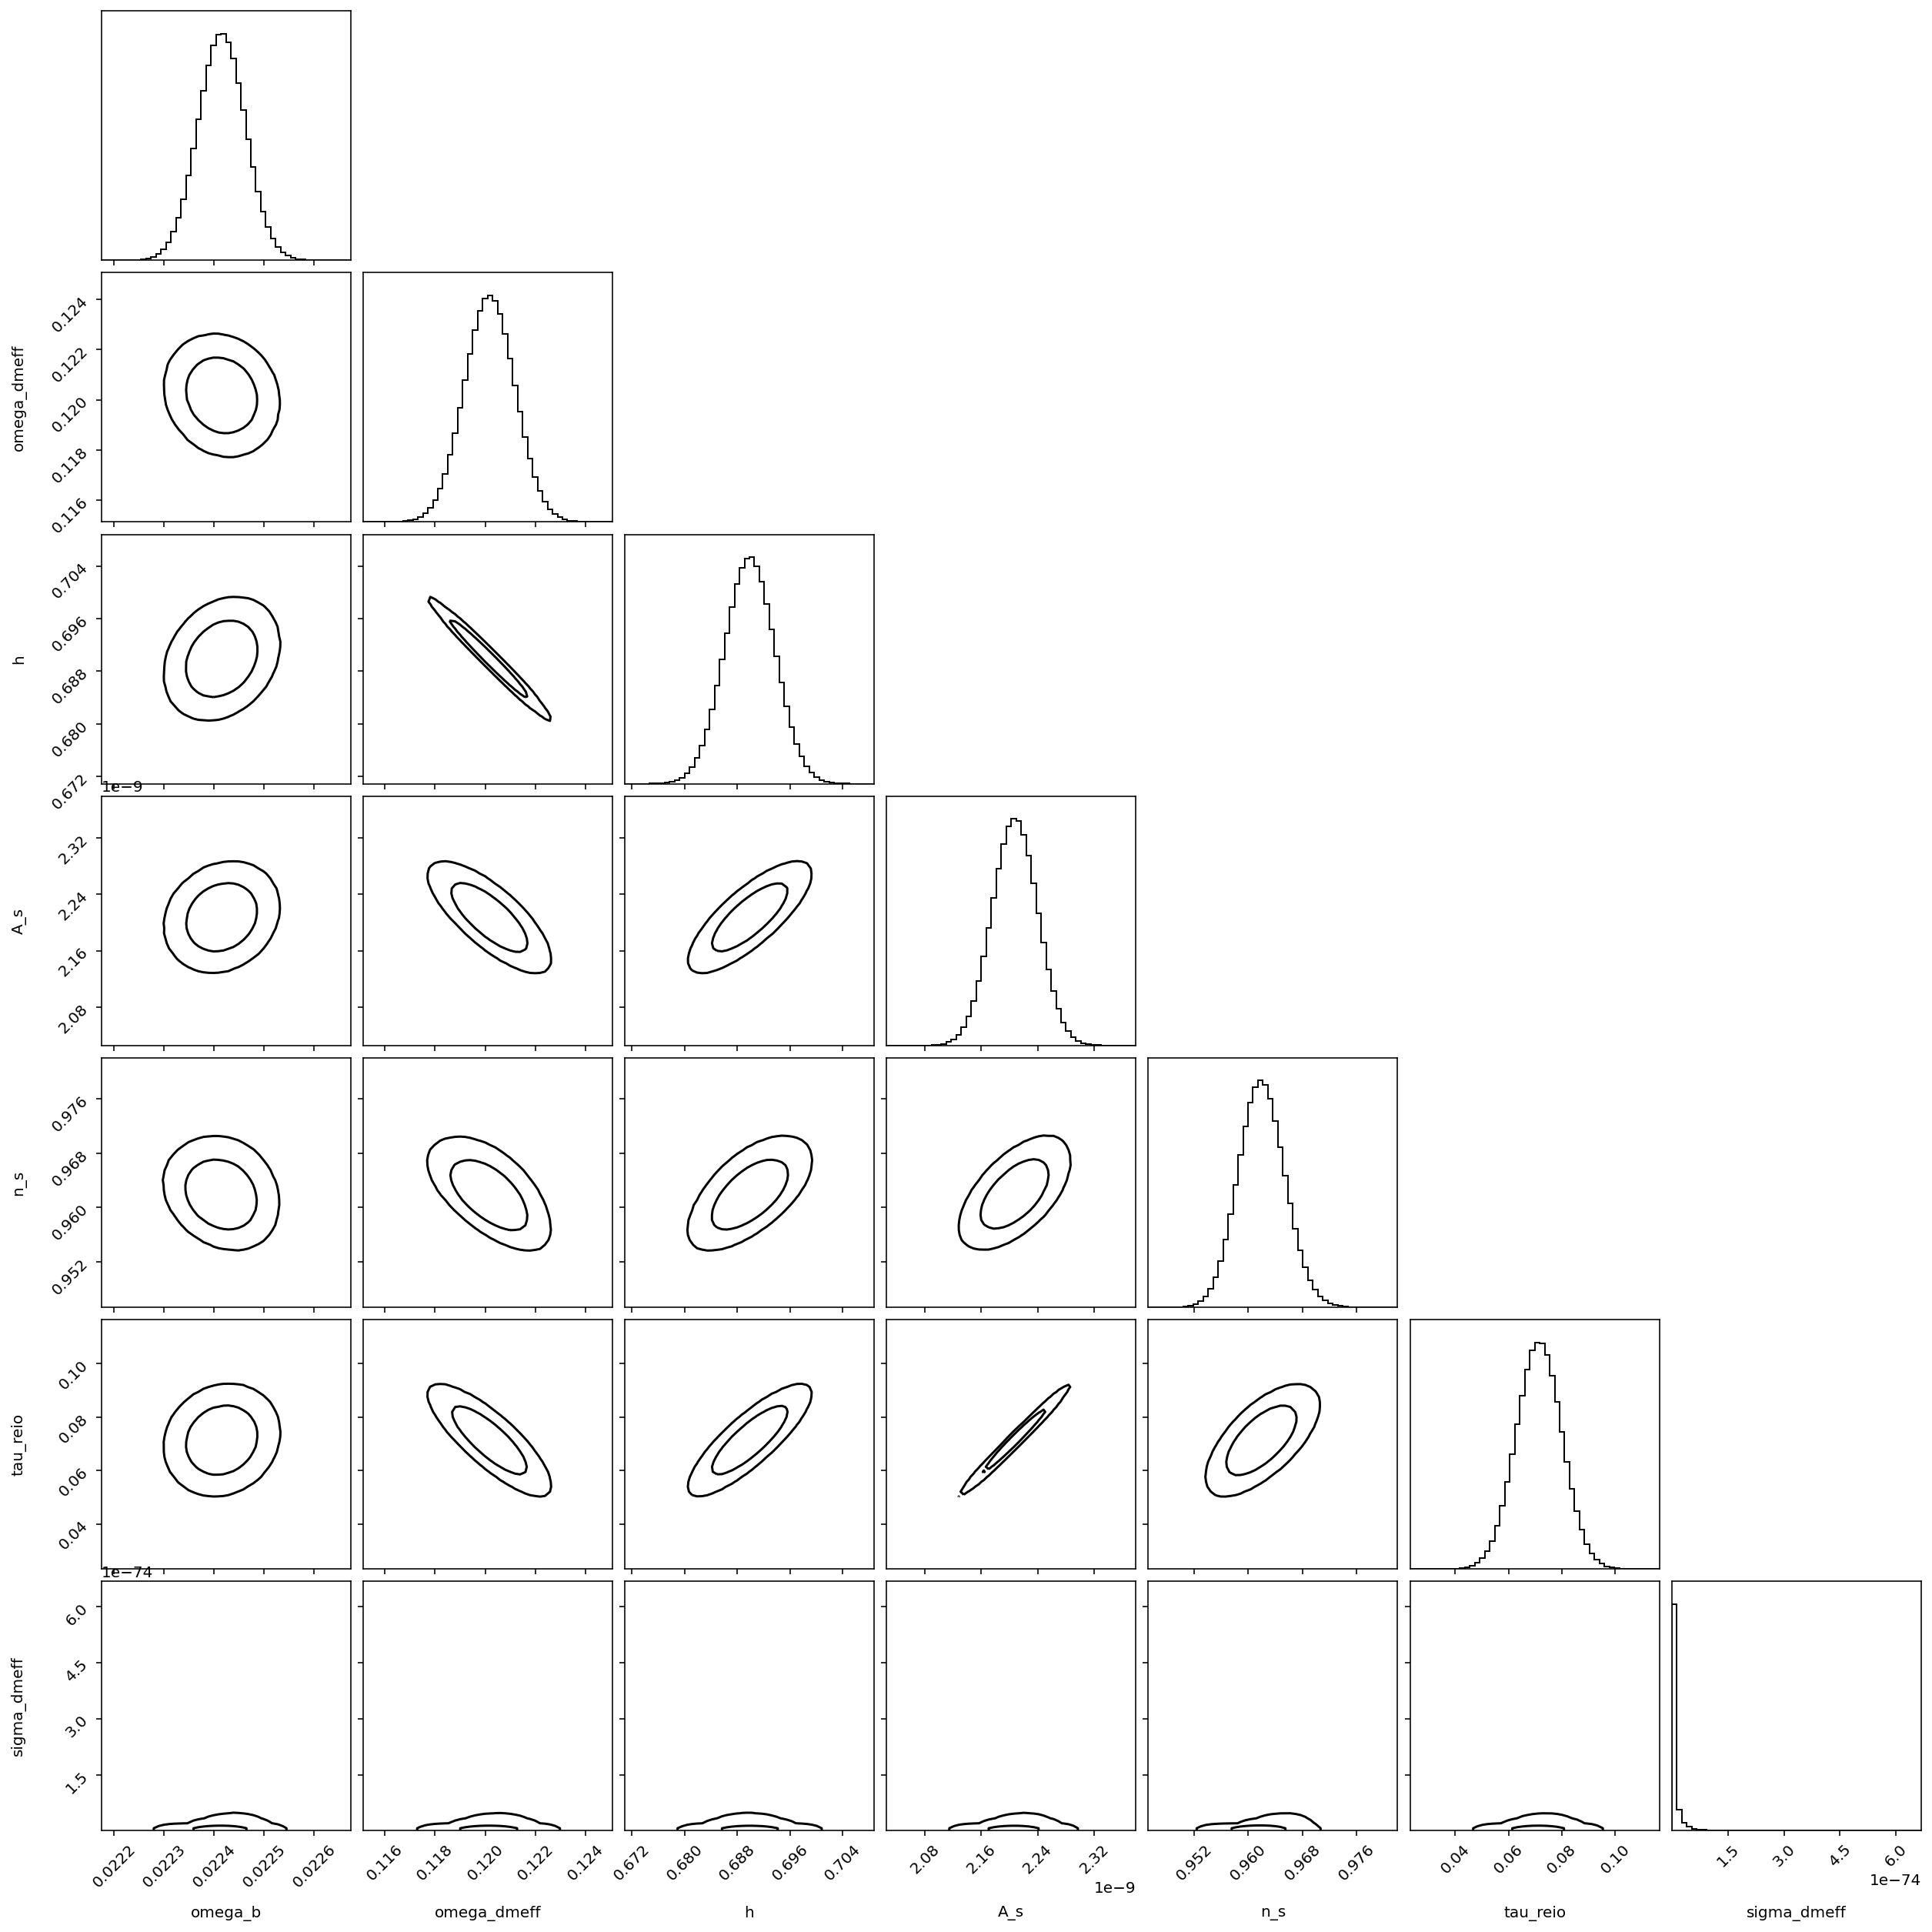

In [10]:
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior

What if we disallow $h < 0.69$ as well?

In [11]:
'''modified_samples = modified_samples[modified_samples.T[2]>0.69]

fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior'''

"modified_samples = modified_samples[modified_samples.T[2]>0.69]\n\nfig, ax = plt.subplots(npar, npar, figsize=(18,18))\ncorner.corner(modified_samples,\n              plot_datapoints=False, plot_density=False, bins=50, \n              levels=(0.68,0.95), lw=2, fig=fig,\n              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_dmeff', r'h',  r'A_s', r'n_s', r'tau_reio', 'sigma_dmeff'],\n              \n              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior"

Here are some possibly useful functions for your case!

In [12]:
def convert_to_cc_array(sig, mass_X):
    """utility function for converting sigma_p to the coupling constant
    
    Parameters
    ----------
        sig (float) : the cross section, sigma_p, possibly a numpy 
        mass_X (float) : dark matter particle mass in GeV
        
    Returns
    -------
        Numpy array that 
    """
    mp = 0.9382720813
    GeV = 1./(0.19732705e-15)
    cc_conversion = (1./( (246.22 * GeV)**4 * np.pi)) * \
        ( (mass_X * mp) / (mass_X + mp) * GeV )**2
    derived_cc = np.sqrt( sig / cc_conversion )
    return derived_cc


def get_95_exclusion(input_cov):
    """convenience function for turning a covariance matrix into a 95% exclusion.
    
    This function is specifically for the sigma_p case with a flat prior on the
    coupling, and positive definite cross section.
    
    Parameters
    ----------
        input_cov (numpy array) : covariance matrix
        
    Returns
    -------
        float, 95% upper limit for a fidcuial centered on zero
    """
    # NOTE: sigma_p MUST BE THE LAST VARIABLE
    samps = get_samps(input_cov, forecast_means_list, num=int(1e8))
    samps = samps[samps.T[-1]>0]
    onesig, twosig = corner.quantile(samps[:,-1], 
                                 [0.68,0.95], 
                                 weights=1./np.sqrt(samps.T[-1]))
    return twosig
    


You would run something like the following. (assuming that sigma_p is the last parameter in the list).


In [13]:
'''samps = get_samps(cov, centers, num=int(1e8)) # get the samples from the covariance
samps = samps[samps.T[-1]>0] # sigma_p cannot be negative
modified = samps.copy()
modified.T[-1] = convert_to_cc_array(modified.T[-1], 1.0) * 1e-6 # convert to 1e6 * cc
    
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio', r'coupling'],
              
              weight=1./np.sqrt(samps.T[-1])); # sqrt(sigma_p) prior'''

"samps = get_samps(cov, centers, num=int(1e8)) # get the samples from the covariance\nsamps = samps[samps.T[-1]>0] # sigma_p cannot be negative\nmodified = samps.copy()\nmodified.T[-1] = convert_to_cc_array(modified.T[-1], 1.0) * 1e-6 # convert to 1e6 * cc\n    \nfig, ax = plt.subplots(npar, npar, figsize=(18,18))\ncorner.corner(modified,\n              plot_datapoints=False, plot_density=False, bins=50, \n              levels=(0.68,0.95), lw=2, fig=fig,\n              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio', r'coupling'],\n              \n              weight=1./np.sqrt(samps.T[-1])); # sqrt(sigma_p) prior"

In [17]:
F = [[256435893581.12686, -29776046383.02648, -7419659687.458143, 8.808901786089398e+17, 3427601134.139993, -4228315504.6077895, 4.768730285225806e+28], [-29776046383.026478, 8336506467.93758, 1028124901.3589946, 4043700566583479.0, 103003744.05470017, 419134005.55432063, -4.943099818545799e+28], [-7419659687.458142, 1028124901.3589945, 357984694.2885425, -3.212505776823924e+16, -128414122.21582194, 116732473.65778747, 2.3713687607686069e+27], [8.808901786089398e+17, 4043700566583473.0, -3.212505776823924e+16, 7.747932644628702e+24, 2.952788095956414e+16, -2.2729754413791104e+16, -1.174913829492672e+36], [3427601134.139993, 103003744.05470017, -128414122.21582194, 2.952788095956414e+16, 122740777.63268231, -77727013.48449327, -5.84821953039549e+27], [-4228315504.6077895, 419134005.55432063, 116732473.65778747, -2.2729754413791104e+16, -77727013.48449329, 100292993.05216442, -2.352640356861205e+26], [4.768730285225806e+28, -4.943099818545799e+28, 2.3713687607686069e+27, -1.174913829492672e+36, -5.84821953039549e+27, -2.352640356861205e+26, 6.574997526908447e+47]]




In [18]:
import math
import numpy as np

cov = np.linalg.inv(F)
forecast_means_list = centers 

get_95_exclusion(cov)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


8.298846135156911e-24

In [40]:
    #S4:
#me
#1.15e-26
#zack:
#6e-27
#aizhan:
#8.17e-27

#Planck:
#me: 3.4494440346544396e-25
#zack: 1.6e-25

In [37]:
get_samps(cov, centers, num=int(1e8))

array([[2.23814490e-02, 1.19221984e-01, 6.92622827e-01, ...,
        9.61742878e-01, 7.73619950e-02, 4.04834171e-12],
       [2.23697304e-02, 1.19075062e-01, 6.93392925e-01, ...,
        9.64286144e-01, 7.66105628e-02, 5.82714684e-12],
       [2.24240877e-02, 1.20329315e-01, 6.89031419e-01, ...,
        9.57662454e-01, 6.85143587e-02, 2.99533804e-12],
       ...,
       [2.24143660e-02, 1.21063764e-01, 6.85804384e-01, ...,
        9.57572830e-01, 6.12959165e-02, 9.39095096e-12],
       [2.23986961e-02, 1.20071166e-01, 6.89733871e-01, ...,
        9.62363063e-01, 7.09615916e-02, 3.22463213e-11],
       [2.23706413e-02, 1.19802415e-01, 6.90763457e-01, ...,
        9.62177576e-01, 7.15069170e-02, 8.17819405e-12]])